<a href="https://colab.research.google.com/github/Rohit9403/Hindi-Vowel---Consonant-Classification/blob/master/Vowel_Consonent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp /content/drive/'My Drive'/PadhAI/train.zip /content/

In [0]:
!unzip /content/train.zip

In [0]:
!cp /content/drive/'My Drive'/PadhAI/test.zip /content/

In [0]:
!unzip /content/test.zip

#DATA LOADER OF data set

Link for the Dataset: [Kaggle Dataset](https://www.kaggle.com/c/padhai-hindi-vowel-consonant-classification/data
)

In [0]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import copy
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()
#transform = transforms.Compose([
#    transforms.ToTensor()])
transform = transforms.Compose([
    transforms.ColorJitter(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), ])

batch_size = 60
full_data=VowelConsonantDataset("/content/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

test_data=VowelConsonantDataset("/content/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=60,shuffle=False)



 

In [58]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#Model Architecture

Mobilenet V2 + 2 Fully connected layer with output features of 10 classes


In [0]:
from torchvision import models

In [0]:
class MyModel(nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(MyModel, self).__init__()
        self.model_snet = models.mobilenet_v2(pretrained=True)
        final_in_features = self.model_snet.classifier[1].in_features
        mod_classifier = list(self.model_snet.classifier.children())[:-1]
        self.model_snet.classifier = nn.Sequential(*mod_classifier)

        self.fc1 = nn.Linear(final_in_features, num_classes1,bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        self.fc2 = nn.Linear(final_in_features, num_classes2,bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.model_snet(x)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        return out1, out2

In [0]:
net  = MyModel(10,10)

In [62]:
print(net)

MyModel(
  (model_snet): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False

In [0]:
#for param in net.model_snet.parameters():
  #param.requires_grad = False

In [64]:
for param in net.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([16, 32, 1, 1])
torch.Size([16])
torch.Size([16])
torch.Size([96, 16, 1, 1])
torch.Size([96])
torch.Size([96])
torch.Size([96, 1, 3, 3])
torch.Size([96])
torch.Size([96])
torch.Size([24, 96, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([144, 24, 1, 1])
torch.Size([144])
torch.Size([144])
torch.Size([144, 1, 3, 3])
torch.Size([144])
torch.Size([144])
torch.Size([24, 144, 1, 1])
torch.Size([24])
torch.Size([24])
torch.Size([144, 24, 1, 1])
torch.Size([144])
torch.Size([144])
torch.Size([144, 1, 3, 3])
torch.Size([144])
torch.Size([144])
torch.Size([32, 144, 1, 1])
torch.Size([32])
torch.Size([32])
torch.Size([192, 32, 1, 1])
torch.Size([192])
torch.Size([192])
torch.Size([192, 1, 3, 3])
torch.Size([192])
torch.Size([192])
torch.Size([32, 192, 1, 1])
torch.Size([32])
torch.Size([32])
torch.Size([192, 32, 1, 1])
torch.Size([192])
torch.Size([192])
torch.

In [0]:
net = net.to(device)

#model Evaluation

In [0]:
def evaluation(dataloader):
    
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Extracting Actual Labels
        _, actual_v = torch.max(labels[:,0,:].data, 1)
        _, actual_c = torch.max(labels[:,1,:].data, 1)
        
        outputs_v,outputs_c = net(inputs)
        _, pred_v = torch.max(outputs_v.data, 1)
        _, pred_c = torch.max(outputs_c.data, 1)
        
        total += labels.size(0)
        correct_v = (pred_v == actual_v)*1
        correct_c = (pred_c == actual_c)*1
        correct_v[correct_v == 0] = 2
        correct_c[correct_c == 0] = 3
        correct += ((correct_v==correct_c)).sum().item()
    return 100 * correct / total

#Model training

In [0]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()

plist = [
        {'params': net.fc1.parameters(), 'lr': 5e-3},
        {'params': net.fc2.parameters(), 'lr': 5e-3}
        ]
lr=0.01
opt = optim.SGD(net.parameters(),lr=0.01,momentum=0.9,nesterov=True)

Epoch: 0/10, Test acc: 69.40, Train acc: 70.54
Epoch: 1/10, Test acc: 72.30, Train acc: 76.92
Epoch: 2/10, Test acc: 76.60, Train acc: 81.73
Epoch: 3/10, Test acc: 77.90, Train acc: 82.81
Epoch: 4/10, Test acc: 78.20, Train acc: 86.12
Epoch: 5/10, Test acc: 78.60, Train acc: 87.63
Epoch: 6/10, Test acc: 79.00, Train acc: 88.13
Epoch: 7/10, Test acc: 80.70, Train acc: 90.07
Epoch: 8/10, Test acc: 78.90, Train acc: 91.10
Epoch: 9/10, Test acc: 80.60, Train acc: 91.67


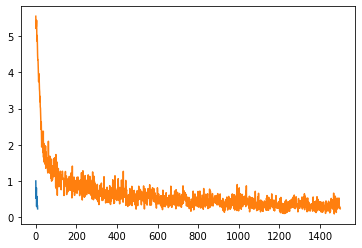

CPU times: user 8min 5s, sys: 4min 11s, total: 12min 17s
Wall time: 12min 17s


In [68]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 10
min_loss = 1000
best_model = None
for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels_v = labels[:,0,:]
        labels_c = labels[:,1,:]
        _, actual_v = torch.max(labels_v.data, 1)
        _, actual_c = torch.max(labels_c.data, 1)
        opt.zero_grad()

        outputs_v, outputs_c = net(inputs)
        loss_v = loss_fn(outputs_v, actual_v)
        loss_c = loss_fn(outputs_c, actual_c)
        loss = torch.add(loss_v,loss_c)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(net.state_dict())
        
        loss_arr.append(loss.item())
        
        del inputs, labels, outputs_v, outputs_c
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(validation_loader), evaluation(train_loader)))
  

net.load_state_dict(best_model)
plt.plot(loss_epoch_arr)
plt.plot(loss_arr)
plt.show()

#Predicting Test data

In [0]:
net.eval()
plist=[]
fn_list=[]
for inputs_test, fn in test_loader:
    inputs_test=inputs_test.to(device)
    out1,out2=net.forward(inputs_test)
    _,pred1=torch.max(out1,1)
    pred1=pred1.tolist()
    _,pred2=torch.max(out2,1)
    pred2=pred2.tolist()
    for x,y,z in zip(pred1,pred2,fn):
        p="V"+str(x)+"_"+"C"+str(y)
        plist.append(p)
        fn_list.append(z)

In [70]:
submission = pd.DataFrame({"ImageId":fn_list, "Class":plist})
submission.head()

,ImageId,Class
0,1163.png,V1_C1
1,784.png,V0_C7
2,640.png,V0_C9
3,9665.png,V9_C6
4,3687.png,V3_C6


In [0]:
submission.to_csv('submission.csv', index=False)